# Logging to a GSD file

## Overview

### Questions

* What is a Logger?
* How can I write thermodynamic and other quantities to a file?
* How can I access that data?

### Objectives

* Describe and give examples of **loggable quantities**.
* Show how to add quantities to a **Logger**.
* Demonstrate **GSD** as a log writer.
* Explain how to read logged quantities from **GSD** files.
* Describe how **namespaces** appear in the names of the logged quantities.

## Boilerplate code

In [1]:
import gsd.hoomd
import hoomd
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
import os

fn = os.path.join(os.getcwd(), 'log.gsd')
![ -e "$fn" ] && rm "$fn"

## Introduction

HOOMD separates logging into three parts: **Loggable quantities**, the **Logger** class, and 
**Writers**.

* **Loggable quantities** are values computed during a simulation.
* The **Logger** class provides a way to collect and name quantities of interest.
* **Writers** write these values out in a format you can use.

In this section, you will use the **GSD Writer** to capture the values of quantities during a simulation run for later analysis.

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from a previous tutorial. 
See [*Introducing Molecular Dyamics*](../01-Introducing-Molecular-Dynamics/00-index.ipynb) for a complete description of this code.

In [3]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu)
sim.create_state_from_gsd(
    filename='../01-Introducing-Molecular-Dynamics/random.gsd')

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell()
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.run(0)

## Loggable quantities

Many classes in HOOMD-blue provide special *properties* called **loggable quantities**.
For example, the **Simulation** class provides `timestep`, `tps`, and others.
The reference documentation labels each of these as _Loggable_.
You can also examine the ``loggables`` property to determine the **loggable quantities**:

In [4]:
sim.loggables

{'timestep': 'scalar',
 'seed': 'scalar',
 'tps': 'scalar',
 'walltime': 'scalar',
 'final_timestep': 'scalar'}

The **ThermodynamicQuantities** class computes a variety of **thermodynamic properties** in MD simulations.
These are all loggable.

In [5]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)
thermodynamic_properties.loggables

{'state': 'state',
 'kinetic_temperature': 'scalar',
 'pressure': 'scalar',
 'pressure_tensor': 'sequence',
 'kinetic_energy': 'scalar',
 'translational_kinetic_energy': 'scalar',
 'rotational_kinetic_energy': 'scalar',
 'potential_energy': 'scalar',
 'degrees_of_freedom': 'scalar',
 'translational_degrees_of_freedom': 'scalar',
 'rotational_degrees_of_freedom': 'scalar',
 'num_particles': 'scalar'}

**Loggable quantities** are class properties or methods.
You can directly access them in your code.

In [6]:
sim.timestep

10000

In [7]:
thermodynamic_properties.kinetic_temperature

1.3101555298226524

Each **loggable quantity** has a **category**, which is listed both in the reference documentation and in ``loggables``.
The **category** is a string that identifies the quantity's type or category.
Example categories include:
* `scalar` - numbers
* `sequence` - arrays of numbers
* `string` - strings of characters
* `particle` - arrays of per-particle values

## Add quantities to a Logger

Add each of the quantities you would like to store to a **Logger**.
The **Logger** will maintain these quantities in a list and provide them to the **Writer** when needed.

In [8]:
logger = hoomd.logging.Logger()

You can add **loggable quantities** from any number of objects to a **Logger**.
**Logger** uses the namespace of the class to assign a unique name for each quantity.
Call `add` to add all quantities provided by `thermodynamic_properties`:

In [9]:
logger.add(thermodynamic_properties)

You can also select specific quantities to add with the `quantities` argument.
Add only the `timestep` and `walltime` quantities from **Simulation**:

In [10]:
logger.add(sim, quantities=['timestep', 'walltime'])

## Writing log quantities to a GSD file

**GSD** files always store trajectories of particle properties.
Set the `log` attribute and **GSD** will also store the selected quantities.

You can store _only_ the logged quantities by using the **Null** filter to select no particles for the trajectory.
This way, you can log thermodynamic properties at a high rate and keep the file size small.


In [11]:
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb',
                             filter=hoomd.filter.Null())
sim.operations.writers.append(gsd_writer)

Assign the logger to include the logged quanties in the GSD file:

In [12]:
gsd_writer.log = logger

The writer triggers and writes to the log file when the simulation runs:

In [13]:
sim.run(100000)

## Reading logged data from a GSD file

You need to close the **GSD** file that `gsd_writer` has open before you can read it.
The following code block deletes the simulation and operations manually so that it is safe to open the file for reading later in this notebook.

In typical workflows, you will run separate simulation and analysis scripts and the **GSD** file will be closed when your simulation script exits.

In [14]:
del sim, gsd_writer, thermodynamic_properties, logger
del integrator, nvt, lj, cell, cpu

Use the `gsd` package to open the file:

In [15]:
traj = gsd.hoomd.open('log.gsd', 'rb')

Each frame in the trajectory has a `log` dictionary that maps quantity names to values.
Inspect this dictionary in the first frame:

In [16]:
traj[0].log

{'md/compute/ThermodynamicQuantities/kinetic_temperature': array([1.4478181]),
 'md/compute/ThermodynamicQuantities/pressure': array([0.36030673]),
 'md/compute/ThermodynamicQuantities/pressure_tensor': array([ 0.31441073,  0.09209052,  0.0141763 ,  0.28827845, -0.00681502,
         0.478231  ]),
 'md/compute/ThermodynamicQuantities/kinetic_energy': array([553.79042325]),
 'md/compute/ThermodynamicQuantities/translational_kinetic_energy': array([553.79042325]),
 'md/compute/ThermodynamicQuantities/rotational_kinetic_energy': array([0.]),
 'md/compute/ThermodynamicQuantities/potential_energy': array([-568.07417284]),
 'md/compute/ThermodynamicQuantities/degrees_of_freedom': array([765.]),
 'md/compute/ThermodynamicQuantities/translational_degrees_of_freedom': array([765.]),
 'md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom': array([0.]),
 'md/compute/ThermodynamicQuantities/num_particles': array([256]),
 'Simulation/timestep': array([11000]),
 'Simulation/walltime': arr

The dictionary keys are verbose names that include the **namespace** of the class which computed the quantity, where `.` has been replaced with `/`.
For example, access the potential energy computed by **ThermodynamicQuantities** with the key `md/compute/ThermodynamicQuantities/potential_energy`.

In [17]:
traj[0].log['md/compute/ThermodynamicQuantities/potential_energy']

array([-568.07417284])

**GSD** stores all quantities in arrays.
It stores scalar quantities such as the system potential energy in length 1 arrays (above) while it stores vector and other array quantities as appropriately sized arrays:

In [18]:
traj[0].log['md/compute/ThermodynamicQuantities/pressure_tensor']

array([ 0.31441073,  0.09209052,  0.0141763 ,  0.28827845, -0.00681502,
        0.478231  ])

**GSD** provides logged quantities individually at each frame in the file.
You can convert this to time-series data with a loop and then plot or analyze it:

In [19]:
timestep = []
walltime = []
potential_energy = []

for frame in traj:
    timestep.append(frame.configuration.step)
    walltime.append(frame.log['Simulation/walltime'][0])
    potential_energy.append(
        frame.log['md/compute/ThermodynamicQuantities/potential_energy'][0])

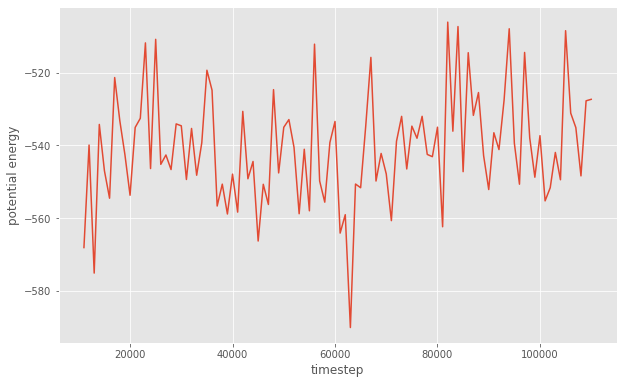

In [20]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.plot(timestep, potential_energy)
ax.set_xlabel('timestep')
ax.set_ylabel('potential energy')
fig

In this section, you have logged quantities to a GSD file during a simulation run and analyzed that data as a time series.
The next section of this tutorial shows you how to save per-particle quantities associated with specific system configurations.

[Index](00-index.ipynb) / [Next section](02-Saving-Array-Quantities.ipynb).